In [21]:
from sat import *
from sat_database import *

# expr = [(1, 2, -3), (-1, -2, 3), (-1, 2, 3)]
#expr = [[1 , 2 , 3] , [1 , 2 , -3] , [1 , -2 , 3] , [1 , -2 , -3] , [-1 , 2 , 3] , [-1 , 2 , -3] , [-1 , -2 , 3]]
expr =  [[~x4 V x1 V x3) ^ (x4 V x3 V ~x1) ^ (x4 V ~x1 V x3)]
sat = ThreeSat(expr=expr, seed=-1)

In [22]:
oracle = general_3sat_circuit(sat)

[3, 4, 5, 6, 7, 8, 9]


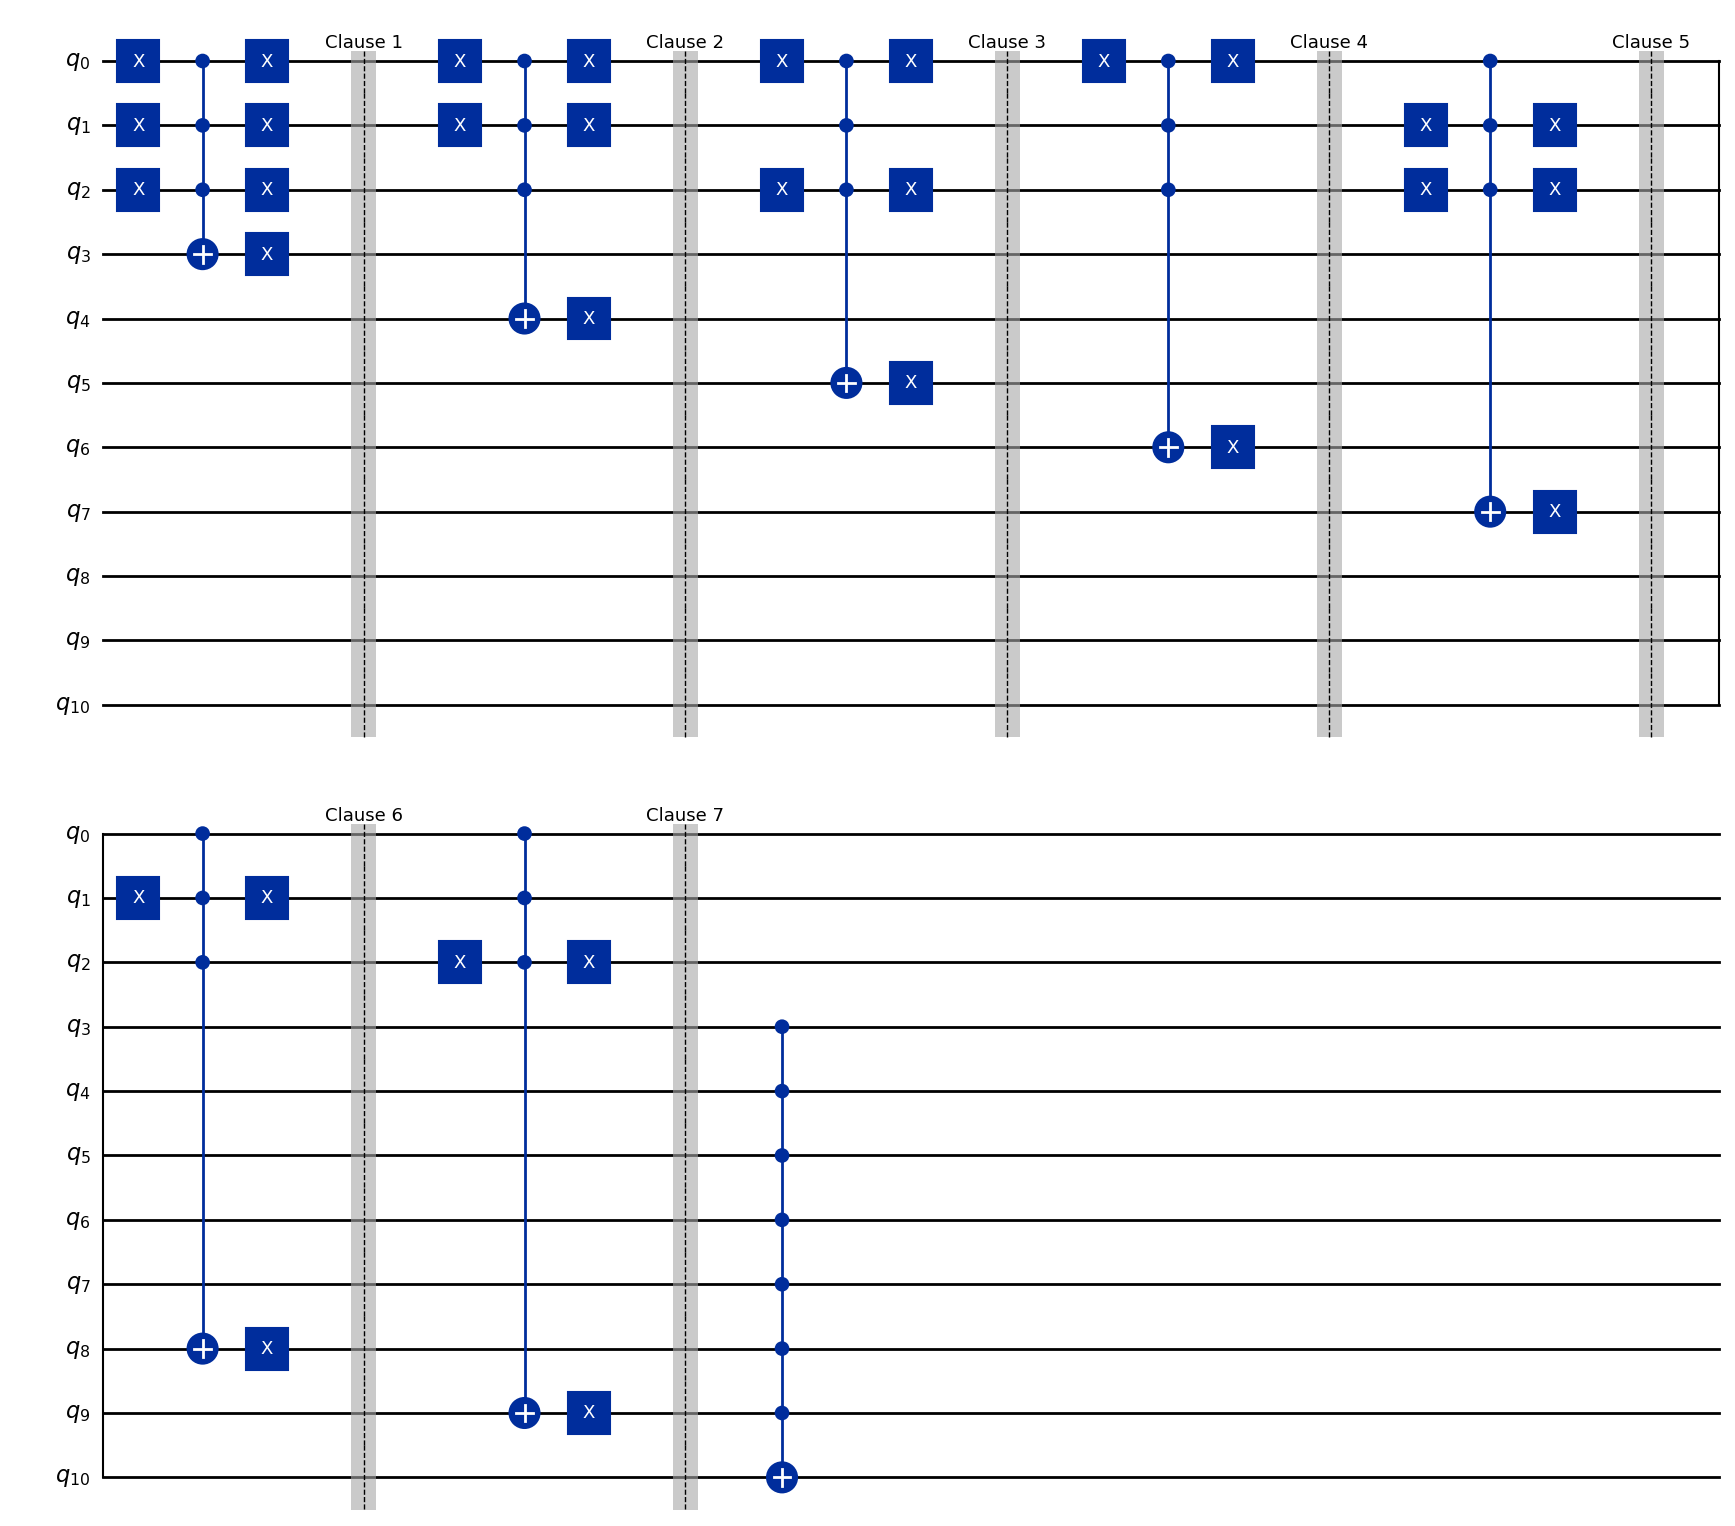

In [23]:
oracle.draw('mpl')

In [5]:
import tweedledum as td
import logging
td.bool_function_compiler.setup_logging(logging.DEBUG)

from sat import *
from qiskit_ibm_runtime import QiskitRuntimeService
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")

/tmp/ipykernel_408917/4251331562.py:13: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN, instance=API_INSTANCE)


In [24]:
import qiskit
import numpy as np
import math
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import grover_operator
from qiskit_ibm_runtime import SamplerV2 as Sampler


def find_solution_grover(oracle, num_input_qubits: int, m=1, only_simulator=True):
    """
    Grover's algorithm using a pre-constructed PHASE-FLIP oracle
    and a MANUAL diffusion operator implementation (using mcx).

    Args:
        oracle: The Qiskit QuantumCircuit implementing the phase-flip oracle.
        num_vertex_qubits: The number of qubits in the search space (N).
        m: The estimated number of solutions (default: 1).
        use_simulator: Flag to use AerSimulator.

    Returns:
        A dictionary of measurement counts.
    """
    n = num_input_qubits
    if n < 1:
        print("Warning: Number of search qubits must be at least 1.")
        return {}
    total_qubits = oracle.num_qubits
    print(f"\nRunning Grover with MANUAL Diffusion (N={n}, Total Qubits={total_qubits})")

    # Ensure oracle has enough qubits for the search space
    if total_qubits < n:
         raise ValueError(f"Oracle qubit count ({total_qubits}) is less than search space ({n}).")

    # ---  Calculate Iterations ---
    if not (m >= 1 and m <= 2**n):
         print(f"Warning: Number of solutions m={m} is outside valid range [1, 2^N]. Assuming m=1.")
         m = 1

    optimal_iterations = 0
    if m < (1 << n): # Avoid error if m=2^n
        optimal_iterations = math.floor(
            math.pi / (4 * math.asin(math.sqrt(m / (1 << n))))
        )
    print(f"Optimal iterations for N={n}, M={m}: {optimal_iterations}")

    if optimal_iterations == 0 and m > 0:
        print("Warning: Optimal iterations calculated as 0. Grover search may not be effective.")
        # Still run once if you want to see oracle effect
        # optimal_iterations = 1

        
    search_circuit = qiskit.QuantumCircuit(total_qubits, n) # Classical bits for measuring N search qubits
    search_circuit.x(n)
    search_circuit.h(n)
    search_circuit.h(range(n))
    grover_op = grover_operator(oracle, reflection_qubits=range(n))
    #search_circuit.compose(grover_op.power(optimal_iterations), inplace=True)
    search_circuit.compose(grover_op.power(1), inplace=True)
    search_circuit.measure(range(n), range(n))
    
    print(grover_op.draw())

    # ---  Run Simulation ---
    simulator = AerSimulator()
    # Transpilation is likely needed because mcx might decompose further
    pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend)
    print("Transpiling final Grover circuit...")
    qc = pass_manager.run(search_circuit)
    print("Running simulation...")
    result = simulator.run(qc, shots=10**4).result()
    counts = result.get_counts()
    return counts
    
sim_counts = find_solution_grover(
    oracle=oracle,
    num_input_qubits=3,
    m=5,
)


Running Grover with MANUAL Diffusion (N=3, Total Qubits=11)
Optimal iterations for N=3, M=5: 0
global phase: π
      ┌───┐     ┌───┐ Clause 1 ┌───┐     ┌───┐ Clause 2 ┌───┐     ┌───┐»
 q_0: ┤ X ├──■──┤ X ├────░─────┤ X ├──■──┤ X ├────░─────┤ X ├──■──┤ X ├»
      ├───┤  │  ├───┤    ░     ├───┤  │  ├───┤    ░     └───┘  │  └───┘»
 q_1: ┤ X ├──■──┤ X ├────░─────┤ X ├──■──┤ X ├────░────────────■───────»
      ├───┤  │  ├───┤    ░     └───┘  │  └───┘    ░     ┌───┐  │  ┌───┐»
 q_2: ┤ X ├──■──┤ X ├────░────────────■───────────░─────┤ X ├──■──┤ X ├»
      └───┘┌─┴─┐├───┤    ░            │           ░     └───┘  │  └───┘»
 q_3: ─────┤ X ├┤ X ├────░────────────┼───────────░────────────┼───────»
           └───┘└───┘    ░          ┌─┴─┐┌───┐    ░            │       »
 q_4: ───────────────────░──────────┤ X ├┤ X ├────░────────────┼───────»
                         ░          └───┘└───┘    ░          ┌─┴─┐┌───┐»
 q_5: ───────────────────░────────────────────────░──────────┤ X ├┤ X ├»
            

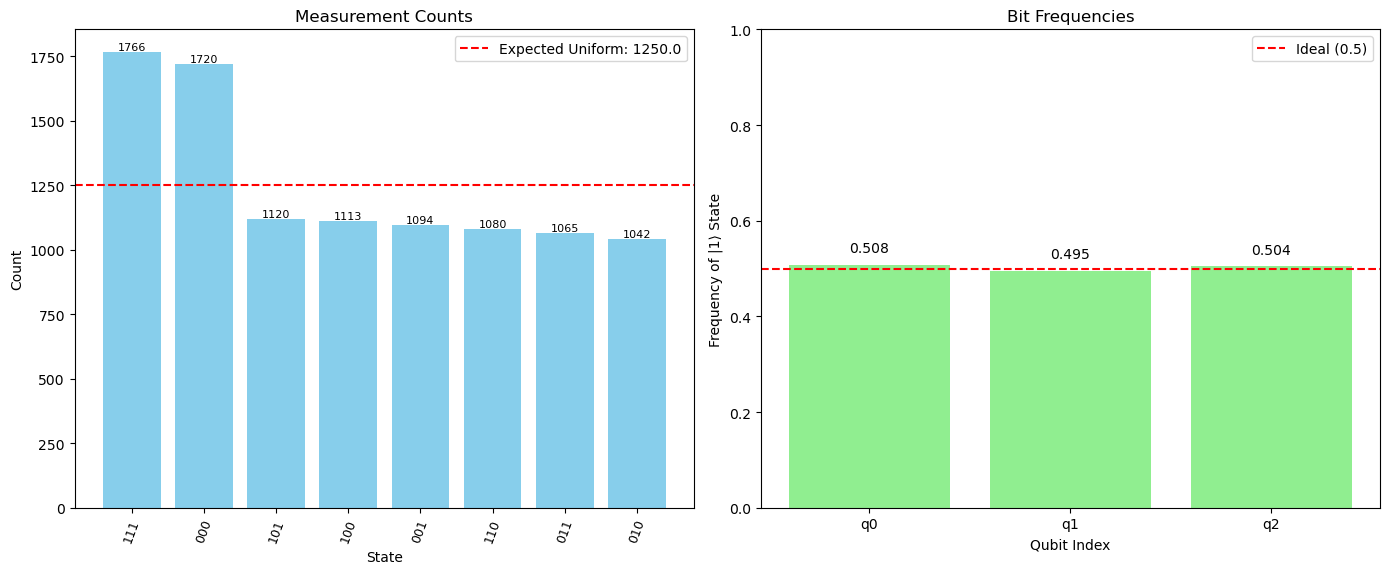

Total samples: 10000
Highest state: 111 (1766 counts, 17.66%)
Lowest state: 010 (1042 counts, 10.42%)
⚠ No clear winner detected. Top state has only 17.7% probability


{'total_samples': 10000,
 'top_state': '111',
 'top_probability': 0.1766,
 'bit_frequencies': {'q0': np.float64(0.5079),
  'q1': np.float64(0.4953),
  'q2': np.float64(0.5045)}}

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize_results(results_dict, title="Quantum Measurement Results"):
    """
    A simple visualization for quantum measurement results.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with quantum states as keys and counts as values
    title : str, optional
        Title for the visualization
    """
    # Basic calculations
    total_samples = sum(results_dict.values())
    n_qubits = len(list(results_dict.keys())[0])
    
    # Sort results by count (descending)
    sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Bar chart of states
    bars = ax1.bar(range(len(sorted_results)), sorted_results.values(), color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Set the x-tick positions and labels
    ax1.set_xticks(range(len(sorted_results)))
    ax1.set_xticklabels(list(sorted_results.keys()), rotation=70, fontsize=9)
    
    # Add uniform expectation line
    expected_uniform = total_samples / len(results_dict)
    ax1.axhline(y=expected_uniform, color='red', linestyle='--', 
                label=f'Expected Uniform: {expected_uniform:.1f}')
    
    ax1.set_title('Measurement Counts')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # 2. Bit frequencies
    bit_counts = np.zeros(n_qubits)
    
    for state, count in results_dict.items():
        for i, bit in enumerate(state):
            if bit == '1':
                bit_counts[i] += count
    
    bit_frequencies = bit_counts / total_samples
    
    bars = ax2.bar(range(n_qubits), bit_frequencies, color='lightgreen')
    ax2.axhline(0.5, color='red', linestyle='dashed', label='Ideal (0.5)')
    
    # Add frequency values on top of bars
    for bar, freq in zip(bars, bit_frequencies):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{freq:.3f}', ha='center', va='bottom')
    
    ax2.set_ylim(0, 1)
    ax2.set_title('Bit Frequencies')
    ax2.set_xlabel('Qubit Index')
    ax2.set_ylabel('Frequency of |1⟩ State')
    ax2.set_xticks(range(n_qubits))
    ax2.set_xticklabels([f'q{i}' for i in range(n_qubits)])
    ax2.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Total samples: {total_samples}")
    print(f"Highest state: {list(sorted_results.keys())[0]} ({list(sorted_results.values())[0]} counts, {list(sorted_results.values())[0]/total_samples*100:.2f}%)")
    print(f"Lowest state: {list(sorted_results.keys())[-1]} ({list(sorted_results.values())[-1]} counts, {list(sorted_results.values())[-1]/total_samples*100:.2f}%)")
    
    # Check for clear winner (probability > 20%)
    top_prob = list(sorted_results.values())[0] / total_samples
    if top_prob > 0.2:
        print(f"✓ Strong signal detected in state {list(sorted_results.keys())[0]} ({top_prob*100:.1f}%)")
    else:
        print(f"⚠ No clear winner detected. Top state has only {top_prob*100:.1f}% probability")
    
    # Check for uniformity
    uniformity_threshold = 0.05  # 5% variation
    max_variation = max(abs(count/total_samples - 1/len(results_dict)) for count in results_dict.values())
    
    if max_variation < uniformity_threshold:
        print(f"⚠ Distribution appears close to uniform (max variation: {max_variation*100:.1f}%)")
    
    # Return a simple summary for programmatic use
    return {
        "total_samples": total_samples,
        "top_state": list(sorted_results.keys())[0],
        "top_probability": top_prob,
        "bit_frequencies": {f"q{i}": freq for i, freq in enumerate(bit_frequencies)}
    }

#hw_counts = job.result()[0].data.c.get_counts()
#print(hw_counts)

simple_visualize_results(sim_counts, "")